---
<a id='setup'></a>
## 1. Setup & Configuration

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# Standard Library
import os
import gzip
import pickle
from pathlib import Path
from itertools import chain
import itertools as it

# Scientific Computing
import numpy as np
import scipy.sparse as ss
from scipy.special import erf

# Data Handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Prefer dill for broader object support; fall back to pickle
try:
    import dill as _pickle
except ImportError:
    import pickle as _pickle

# Local VELO Toy Model Modules
from LHCB_Velo_Toy_Models.state_event_generator import StateEventGenerator
from LHCB_Velo_Toy_Models import state_event_model
from LHCB_Velo_Toy_Models.state_event_model import Segment, Track
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian, get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
from LHCB_Velo_Toy_Models.lhcb_tracking_plots import plot_all, plot_all_extended

# HHL Algorithm (Quantum)
from hhl_algorithm import HHLAlgorithm as hhl

# Legacy modules (from old/ directory)
from old.analysis_worker import *
from old.toy_experiment_batch_worker import run_one

In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Data directories
ROOT_DIR = Path("/data/bfys/gscriven/Velo_toy")
EXPERIMENT_DIR = ROOT_DIR / "runs_6"  # Updated to latest experiment

# Default run number for batch analysis
DEFAULT_RUN = 6

# Default physics parameters
DEFAULT_PARAMS = {
    'meas': 0,              # Measurement noise (hit resolution)
    'coll': 0,              # Multiple scattering
    'ghost': 0,             # Ghost hit rate
    'drop': 0,              # Hit drop rate (inefficiency)
    'repeat': 0,            # Repeat index for statistics
    'thresh_flag': True,    # Use ERF threshold (True) or step function (False)
    'epsilon_window': 1,    # Epsilon window scale factor
}

# Plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

---
<a id='utilities'></a>
## 2. Utility Functions

In [4]:
# =============================================================================
# DATA SUBSETTING
# =============================================================================

def sub_set_data(df: pd.DataFrame, col_val_dict: dict) -> pd.DataFrame:
    """
    Filter DataFrame by multiple column-value pairs.
    
    Parameters:
        df: Input DataFrame
        col_val_dict: Dictionary of {column_name: value} to filter by
    
    Returns:
        Filtered DataFrame
    """
    sub = df
    for col, val in col_val_dict.items():
        sub = sub[sub[col] == val]
    return sub

In [5]:
# =============================================================================
# DATA LOADING FUNCTIONS
# =============================================================================

def load_snapshot(p: Path):
    """Load a gzipped pickle file."""
    with gzip.open(p, "rb") as f:
        return _pickle.load(f)


def read_experiment_metrics(root: str = "/data/bfys/gscriven/Velo_toy/", 
                            run: int = None) -> pd.DataFrame:
    """
    Read and merge all metrics.csv files from batch directories.
    
    Parameters:
        root: Base directory path
        run: Run number (uses runs_{run}/ subdirectory if specified)
    
    Returns:
        Merged DataFrame with all metrics
    """
    if run is None:
        root = Path(root)
    else:
        root = Path(f"/data/bfys/gscriven/Velo_toy/runs_{run}/")

    print(f"Searching in: {root}")
    metrics_files = sorted(root.glob("batch_*/metrics.csv"))
    print(f"Found {len(metrics_files)} metrics.csv files")

    dfs = []
    for f in metrics_files:
        try:
            if f.stat().st_size > 0:
                dfs.append(pd.read_csv(f))
        except Exception as e:
            print(f"⚠️ Skipping {f}: {e}")

    if dfs:
        merged = pd.concat(dfs, ignore_index=True)
        out_path = root / "metrics_merged.csv"
        merged.to_csv(out_path, index=False)
        print(f"✅ Merged {len(dfs)} files into: {out_path}")
        print(f"   Total rows: {len(merged)}")
        return merged
    else:
        print("⚠️ No non-empty metrics.csv files found")
        return None


def read_experiment_events(root: str = "/data/bfys/gscriven/Velo_toy/", 
                           run: int = None) -> dict:
    """
    Read and unpickle all .pkl.gz event files.
    
    Parameters:
        root: Base directory path
        run: Run number (uses runs_{run}/ subdirectory if specified)
    
    Returns:
        Dictionary of {filename: event_object}
    """
    if run is None:
        root = Path(root)
    else:
        root = Path(f"/data/bfys/gscriven/Velo_toy/runs_{run}/")

    print(f"Searching in: {root}")
    event_files = sorted(root.glob("batch_*/*/*.pkl.gz"))
    print(f"Found {len(event_files)} events.pkl.gz files")

    all_events = {}
    for f in event_files:
        try:
            if f.stat().st_size > 0:
                events = load_snapshot(f)
                all_events[f.name] = events
        except Exception as e:
            print(f"⚠️ Skipping {f}: {e}")

    print(f"✅ Loaded events from {len(event_files)} files")
    print(f"   Total events: {len(all_events)}")
    return all_events


def extract_events(event_dicts: dict) -> dict:
    """
    Convert raw event dictionaries to structured Event objects.
    
    Parameters:
        event_dicts: Dictionary from read_experiment_events()
    
    Returns:
        Dictionary with truth_event, noisy_event, reco_event for each file
    """
    events = {}
    for filename, event in event_dicts.items():
        reco_event = state_event_model.Event(
            detector_geometry=event['truth_event'].detector_geometry,
            tracks=event['reco_event'].tracks,
            hits=list(it.chain.from_iterable(event['reco_event'].hits)),
            segments=list(it.chain.from_iterable(event['reco_event'].segments)),
            modules=event['truth_event'].detector_geometry.module_id
        )
        events[filename] = {
            'truth_event': event['truth_event'],
            'noisy_event': event['noisy_event'],
            'reco_event': reco_event
        }
    return events

---
<a id='physics'></a>
## 3. Physics Functions

Based on the Hamiltonian formulation from Nicotra 2023:

The cost function uses an error function smoothing:
$$C(r) = \frac{1}{2} \left(1 + \text{erf}\left(\frac{\epsilon - r}{\sigma \sqrt{2}}\right)\right)$$

Where:
- $\epsilon$ is the threshold angle
- $\sigma$ is the smoothing parameter
- $r$ is the angle between segments

In [6]:
# =============================================================================
# PHYSICS FUNCTIONS
# =============================================================================

def threshold(s: float, theta_c: float, theta_m: float, theta_min: float) -> float:
    """
    Compute threshold angle from physics parameters.
    
    Based on: Nicotra 2023, J. Inst. 18 P11028
    
    The threshold combines multiple scattering (theta_c), 
    measurement resolution (theta_m), and minimum angle (theta_min).
    
    Parameters:
        s: Scale factor
        theta_c: Collision/multiple scattering angle
        theta_m: Measurement resolution angle
        theta_min: Minimum angular resolution
    
    Returns:
        Combined threshold angle: s * sqrt(theta_c² + theta_m² + theta_min²)
    """
    return np.sqrt(theta_c**2 + theta_m**2 + theta_min**2) * s


def compute_cost(epsilon: float, sigma: float, r: float) -> float:
    """
    Compute cost function value using error function smoothing.
    
    This implements the smoothed step function from the Hamiltonian:
    C(r) = 1/2 * (1 + erf((ε - r) / (σ * √2)))
    
    Parameters:
        epsilon: Threshold angle (radians)
        sigma: Smoothing parameter (erf width)
        r: Angle between segments (radians)
    
    Returns:
        Cost value in [0, 1] - high for good segment pairs, low for bad
    """
    return 0.5 * (1 + erf((epsilon - r) / (sigma * np.sqrt(2))))


def compute_step(epsilon: float, sigma: float, cos_theta: float) -> int:
    """
    Compute hard step function value (binary threshold).
    
    Parameters:
        epsilon: Threshold angle (radians)
        sigma: Unused (for API compatibility with compute_cost)
        cos_theta: Cosine of angle between segments
    
    Returns:
        1 if angle < epsilon, else 0
    """
    theta = np.arccos(cos_theta)
    return 1 if theta < epsilon else 0

---
<a id='data-loading'></a>
## 4. Data Loading

Load experiment data from batch runs.

In [7]:
# =============================================================================
# LOAD DATA
# =============================================================================

run = DEFAULT_RUN

# Load metrics and events
metrics = read_experiment_metrics(run=run)
events = read_experiment_events(run=run)

# Extract structured events
e = extract_events(events)

# Get file list
files = metrics['file'] if metrics is not None else None

Searching in: /data/bfys/gscriven/Velo_toy/runs_6
Found 180 metrics.csv files
✅ Merged 180 files into: /data/bfys/gscriven/Velo_toy/runs_6/metrics_merged.csv
   Total rows: 3600
Searching in: /data/bfys/gscriven/Velo_toy/runs_6
✅ Merged 180 files into: /data/bfys/gscriven/Velo_toy/runs_6/metrics_merged.csv
   Total rows: 3600
Searching in: /data/bfys/gscriven/Velo_toy/runs_6
Found 3600 events.pkl.gz files
Found 3600 events.pkl.gz files
✅ Loaded events from 3600 files
   Total events: 1800
✅ Loaded events from 3600 files
   Total events: 1800


In [8]:
# Quick data summary
if metrics is not None:
    print("\n=== Data Summary ===")
    print(f"Total experiments: {len(metrics)}")
    print(f"\nParameter columns:")
    for col in [c for c in metrics.columns if c.startswith('p_')]:
        unique_vals = metrics[col].unique()
        print(f"  {col}: {len(unique_vals)} unique values")
    print(f"\nMetric columns: {len([c for c in metrics.columns if c.startswith('m_')])}")


=== Data Summary ===
Total experiments: 3600

Parameter columns:
  p_hit_res: 1 unique values
  p_multi_scatter: 1 unique values
  p_ghost_rate: 1 unique values
  p_drop_rate: 1 unique values
  p_repeat: 20 unique values
  p_scale: 5 unique values
  p_epsilon: 5 unique values
  p_layers: 1 unique values
  p_dz_mm: 1 unique values
  p_thresh_flag: 2 unique values
  p_eps_win: 5 unique values
  p_theta_threshold: 5 unique values
  p_erf_sigma: 9 unique values
  p_phi_max: 1 unique values
  p_theta_max: 1 unique values

Metric columns: 28


---
<a id='cost-function'></a>
## 5. Cost Function Visualization

Visualize the cost function behavior for different parameter values.

In [9]:
# =============================================================================
# COST FUNCTION ANALYSIS FUNCTIONS
# =============================================================================

def find_hist_angles(event) -> list:
    """
    Extract angles between consecutive segments in all tracks.
    
    Parameters:
        event: Event object containing tracks with segments
    
    Returns:
        List of angles (radians) between consecutive segment pairs
    """
    angles = []
    for track in event.tracks:
        segments_in_track = track.segments
        for i in range(len(segments_in_track) - 1):
            seg1 = segments_in_track[i]
            seg2 = segments_in_track[i + 1]
            theta = np.arccos(seg1 * seg2)  # Uses __mul__ for dot product
            angles.append(theta)
    return angles


def plot_cost_histogram(test_event: dict, event_type: str = 'all', 
                        log_scale: bool = False):
    """
    Plot histogram of angles with cost function overlay.
    
    Parameters:
        test_event: Event dictionary with 'params' key
        event_type: 'all', 'truth_event', 'noisy_event', or 'reco_event'
        log_scale: Use logarithmic y-axis
    """
    # Extract events from global e dictionary
    first_key = list(e.keys())[0]
    truth_event = e[first_key]['truth_event']
    noisy_event = e[first_key]['noisy_event']
    reco_event = e[first_key]['reco_event']
    
    # Get angles for all event types
    true_angles = find_hist_angles(truth_event)
    noisy_angles = find_hist_angles(noisy_event)
    reco_angles = find_hist_angles(reco_event)
    
    # Get parameters from test_event
    epsilon = test_event['params']['scale'] * test_event['params']['epsilon']
    erf_sigma = test_event['params']['erf_sigma']
    
    # Compute costs
    costs_true = [compute_cost(epsilon, erf_sigma, angle) for angle in true_angles]
    costs_noisy = [compute_cost(epsilon, erf_sigma, angle) for angle in noisy_angles]
    costs_reco = [compute_cost(epsilon, erf_sigma, angle) for angle in reco_angles]

    def apply_log_scale(ax):
        """Helper function to consistently apply log scale."""
        if log_scale:
            ax.set_yscale('log')

    if event_type == 'all':
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Truth event
        ax1 = axes[0, 0]
        ax1.hist(true_angles, bins=50, alpha=0.7, color='blue', label='Angles')
        ax1.axvline(x=np.mean(true_angles), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(true_angles):.6f}')
        ax1.axvline(x=epsilon, color='black', linestyle='--', 
                    label=f'Epsilon: {epsilon:.6f}')
        ax1.set_xlabel('Angle (radians)')
        ax1.set_ylabel('Frequency', color='blue')
        ax1.set_title('Truth Event - Angles Between Segments')
        apply_log_scale(ax1)
        
        ax2 = ax1.twinx()
        ax2.scatter(true_angles, costs_true, color='orange', s=20, alpha=0.8, 
                    label='Cost Values')
        ax2.set_ylabel('Cost Function Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        apply_log_scale(ax2)
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        # Noisy event
        ax3 = axes[0, 1]
        ax3.hist(noisy_angles, bins=50, alpha=0.7, color='green', label='Angles')
        ax3.axvline(x=np.mean(noisy_angles), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(noisy_angles):.6f}')
        ax3.axvline(x=epsilon, color='black', linestyle='--', 
                    label=f'Epsilon: {epsilon:.6f}')
        ax3.set_xlabel('Angle (radians)')
        ax3.set_ylabel('Frequency', color='green')
        ax3.set_title('Noisy Event - Angles Between Segments')
        apply_log_scale(ax3)
        
        ax4 = ax3.twinx()
        ax4.scatter(noisy_angles, costs_noisy, color='purple', s=20, alpha=0.8, 
                    label='Cost Values')
        ax4.set_ylabel('Cost Function Value', color='purple')
        ax4.tick_params(axis='y', labelcolor='purple')
        apply_log_scale(ax4)
        
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines4, labels4 = ax4.get_legend_handles_labels()
        ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper right')
        
        # Reco event
        ax5 = axes[1, 0]
        ax5.hist(reco_angles, bins=50, alpha=0.7, color='red', label='Angles')
        ax5.axvline(x=np.mean(reco_angles) if reco_angles else 0, color='red', 
                    linestyle='--', label=f'Mean: {np.mean(reco_angles) if reco_angles else 0:.6f}')
        ax5.axvline(x=epsilon, color='black', linestyle='--', 
                    label=f'Epsilon: {epsilon:.6f}')
        ax5.set_xlabel('Angle (radians)')
        ax5.set_ylabel('Frequency', color='red')
        ax5.set_title('Reconstructed Event - Angles Between Segments')
        apply_log_scale(ax5)
        
        ax6 = ax5.twinx()
        ax6.scatter(reco_angles, costs_reco, color='brown', s=20, alpha=0.8, 
                    label='Cost Values')
        ax6.set_ylabel('Cost Function Value', color='brown')
        ax6.tick_params(axis='y', labelcolor='brown')
        apply_log_scale(ax6)
        
        lines5, labels5 = ax5.get_legend_handles_labels()
        lines6, labels6 = ax6.get_legend_handles_labels()
        ax5.legend(lines5 + lines6, labels5 + labels6, loc='upper right')
        
        # Combined comparison
        ax7 = axes[1, 1]
        ax7.hist(true_angles, bins=50, alpha=0.5, color='blue', 
                 label='Truth', density=True)
        ax7.hist(noisy_angles, bins=50, alpha=0.5, color='green', 
                 label='Noisy', density=True)
        ax7.hist(reco_angles, bins=50, alpha=0.5, color='red', 
                 label='Reco', density=True)
        ax7.axvline(x=epsilon, color='black', linestyle='--', 
                    label=f'ε: {epsilon:.6f}')
        ax7.set_xlabel('Angle (radians)')
        ax7.set_ylabel('Density')
        ax7.set_title('All Events - Comparison')
        apply_log_scale(ax7)
        
        ax8 = ax7.twinx()
        ax8.scatter(true_angles, costs_true, color='orange', s=15, alpha=0.6, 
                    label='Truth Cost')
        ax8.scatter(noisy_angles, costs_noisy, color='purple', s=15, alpha=0.6, 
                    label='Noisy Cost')
        ax8.scatter(reco_angles, costs_reco, color='brown', s=15, alpha=0.6, 
                    label='Reco Cost')
        ax8.set_ylabel('Cost Function Value')
        apply_log_scale(ax8)
        
        lines7, labels7 = ax7.get_legend_handles_labels()
        lines8, labels8 = ax8.get_legend_handles_labels()
        ax7.legend(lines7 + lines8, labels7 + labels8, loc='upper right', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    else:
        # Single event plot
        event_configs = {
            'truth_event': (true_angles, costs_true, 'blue', 'Truth Event'),
            'noisy_event': (noisy_angles, costs_noisy, 'green', 'Noisy Event'),
            'reco_event': (reco_angles, costs_reco, 'red', 'Reconstructed Event')
        }
        
        angles, costs, color, title = event_configs[event_type]
        
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        ax1.hist(angles, bins=50, alpha=0.7, color=color)
        ax1.axvline(x=np.mean(angles) if angles else 0, color='red', linestyle='--', 
                    label=f'Mean: {np.mean(angles) if angles else 0:.6f}')
        ax1.axvline(x=epsilon, color='black', linestyle='--', 
                    label=f'Epsilon: {epsilon:.6f}')
        ax1.set_xlabel('Angle (radians)')
        ax1.set_ylabel('Frequency', color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        apply_log_scale(ax1)

        ax2 = ax1.twinx()
        ax2.scatter(angles, costs, color='orange', s=30, 
                    label='Cost Function Values', alpha=0.8)
        ax2.set_ylabel('Cost Function Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        apply_log_scale(ax2)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.title(f'{title} - Angles Between Segments with Cost Function')
        plt.tight_layout()
        plt.show()

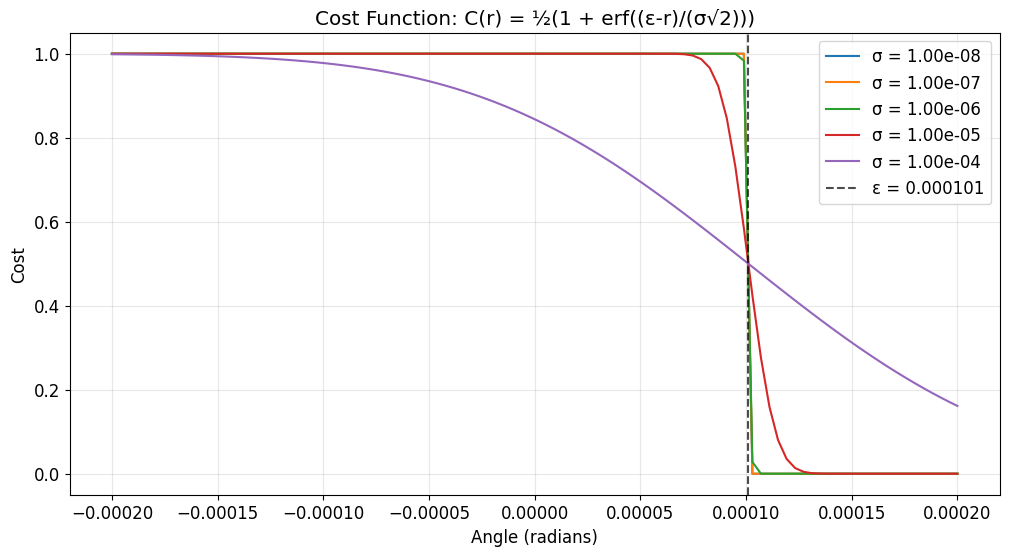

In [10]:
# Plot cost function for different sigma values
if metrics is not None:
    epsilon = metrics['p_theta_threshold'].iloc[0]
    sigmas = metrics['p_erf_sigma'].unique()
    
    rads = np.linspace(-0.0002, 0.0002, 100)
    
    plt.figure(figsize=(12, 6))
    for s in sigmas[:5]:  # Limit to first 5 for clarity
        costs = [compute_cost(epsilon, s, r) for r in rads]
        plt.plot(rads, costs, label=f'σ = {s:.2e}')
    
    plt.axvline(x=epsilon, linestyle='--', color='black', alpha=0.7, 
                label=f'ε = {epsilon:.6f}')
    plt.xlabel('Angle (radians)')
    plt.ylabel('Cost')
    plt.title(f'Cost Function: C(r) = ½(1 + erf((ε-r)/(σ√2)))')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

---
<a id='single-events'></a>
## 6. Single Event Analysis

Analyze individual events and visualize tracks.

In [11]:
# =============================================================================
# SINGLE EVENT PARAMETERS
# =============================================================================

# Parameters for single event runs
meas = 0          # Measurement noise
coll = 0          # Multiple scattering
ghost = 0         # Ghost hit rate
drop = 0          # Hit drop rate
repeat = 0        # Repeat index
thresh_flag = True  # Use ERF function
epsilon_window = 1  # Epsilon scale
outdir = Path('/data/bfys/gscriven/Velo_toy/small_experiment')

In [12]:
# Select a test event (scale=2 example)
test_event = [ev for ev in events.items() if ev[1]['params']['scale'] == 2]
if test_event:
    test_event = test_event[0]
    print(f"Selected event: {test_event[0]}")
    print(f"Parameters: {test_event[1]['params']}")

Selected event: events_m1e-05_c0.0001_g0.0_d0.0_r0_s2_t_1_e_1e-07_phi0.02_theta0.2.pkl.gz
Parameters: {'hit_res': 1e-05, 'multi_scatter': 0.0001, 'ghost_rate': 0.0, 'drop_rate': 0.0, 'repeat': 0, 'scale': 2.0, 'epsilon': 0.00020056262690107103, 'layers': 5, 'dz_mm': 33.0, 'thresh_flag': 1, 'eps_win': 0.00020056262690107103, 'theta_threshold': 0.00020056262690107103, 'erf_sigma': 1e-07, 'phi_max': 0.02, 'theta_max': 0.2}


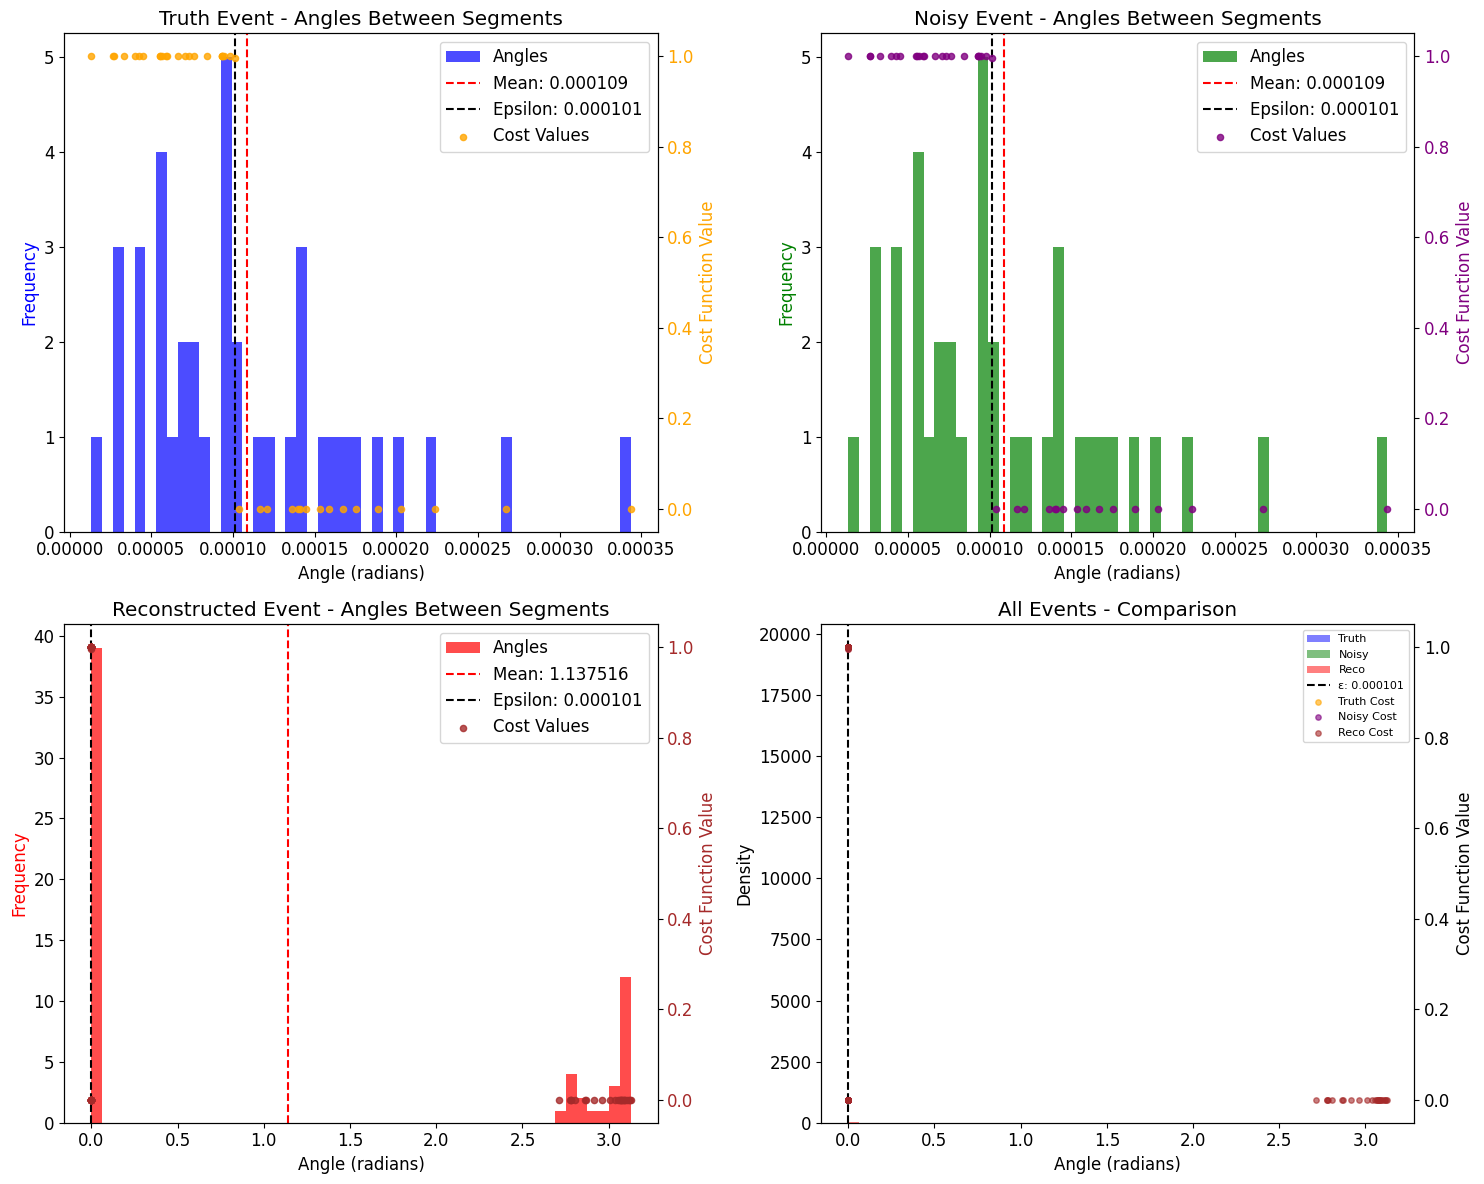

In [13]:
# Plot cost histogram for selected event
if test_event:
    es = list(events.values())
    plot_cost_histogram(es[0], 'all', log_scale=False)

In [14]:
# Example: Load and analyze a specific event file
example_file = list(e.keys())[0] if e else None
if example_file:
    print(f"\nAnalyzing event: {example_file}")
    
    # Validate reconstruction
    val = evl(e[example_file]['truth_event'], e[example_file]['reco_event'])
    val.print_metrics()


Analyzing event: events_m1e-05_c0.0001_g0.0_d0.0_r0_s1_t_0_e_1e-08_phi0.02_theta0.2.pkl.gz
                          EVENT VALIDATION METRICS (standardized)                           
Truth tracks (all)                                                                       13
Truth tracks (reconstructible)                                                           13
Reco tracks (candidates after reco-level gate)                                            1
--------------------------------------------------------------------------------------------
Reconstruction efficiency (truth-level)                                              0.0769
Ghost rate (per candidate reco)                                                      0.0000
Clone fraction (per candidate reco)                                                  0.0000
Clone fraction (among matched reco)                                                  0.0000
------------------------------------------------------------------------------

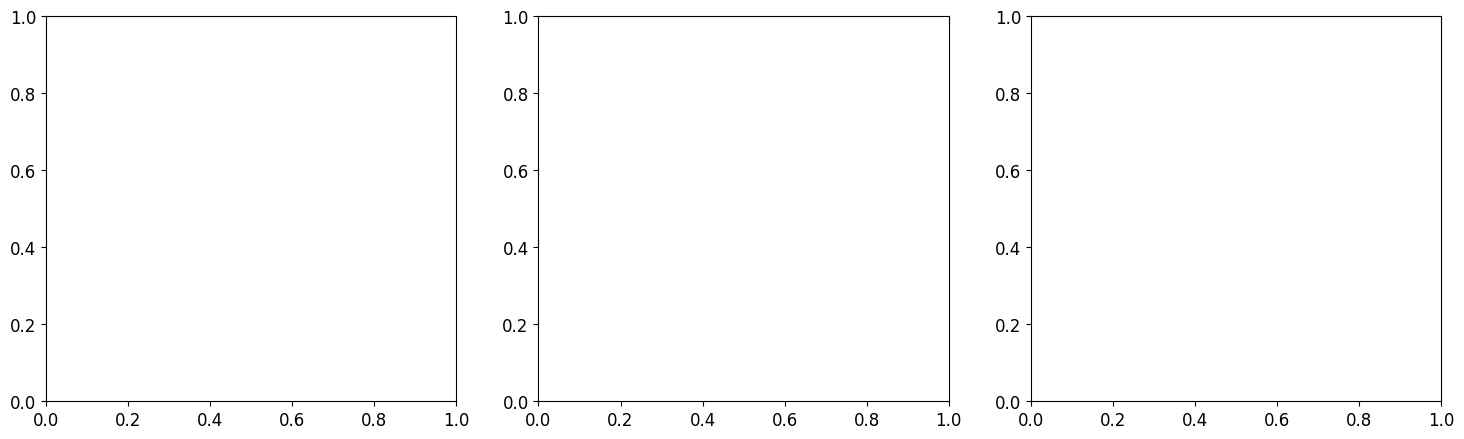

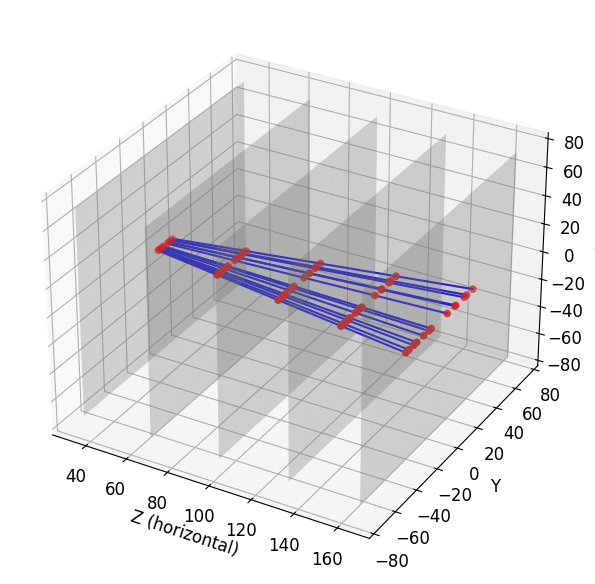

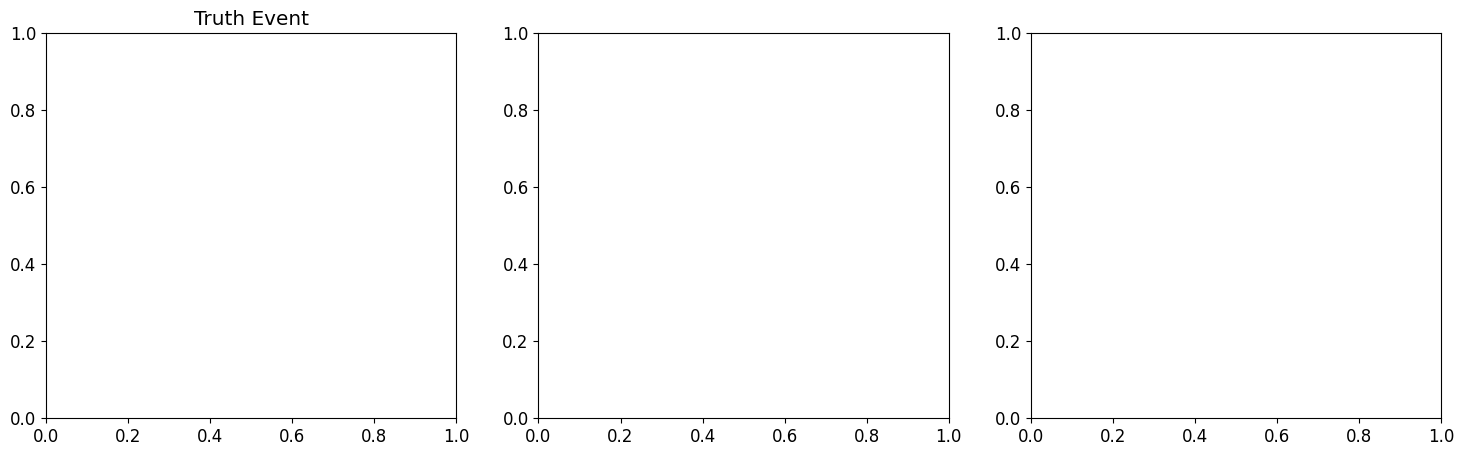

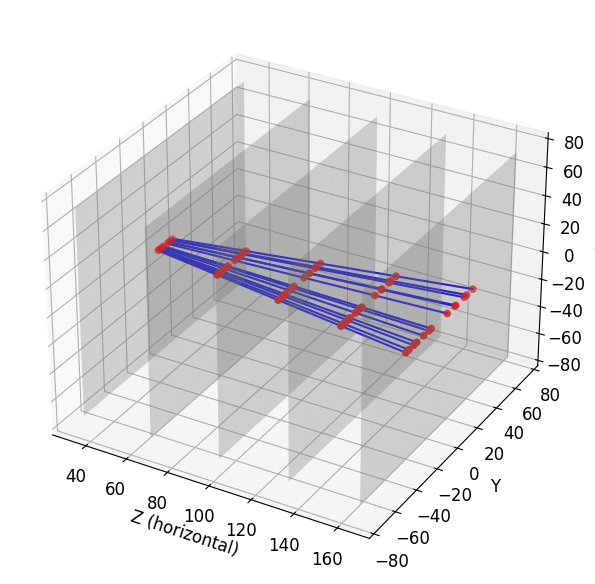

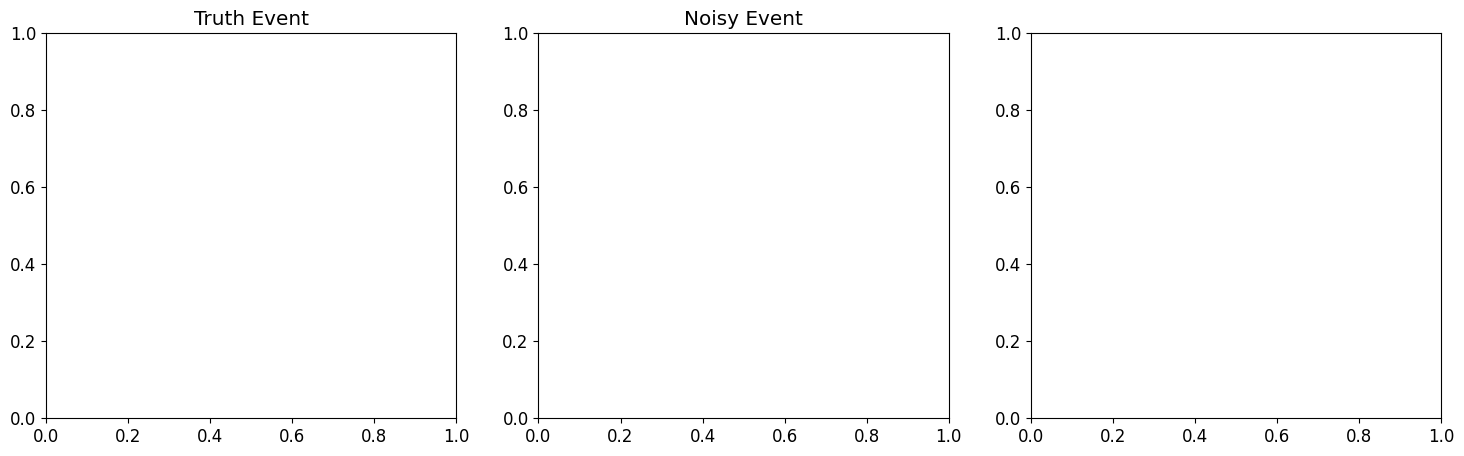

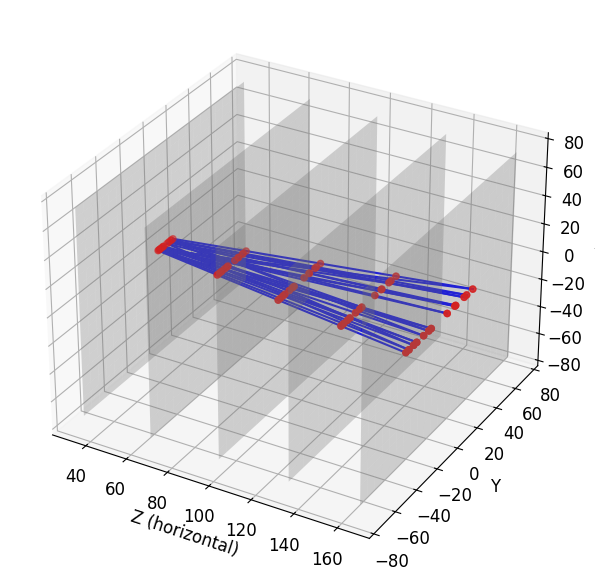

<Figure size 1000x600 with 0 Axes>

In [15]:
# Plot event visualizations
if example_file:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    plt.sca(axes[0])
    e[example_file]['truth_event'].plot_segments()
    axes[0].set_title('Truth Event')
    
    plt.sca(axes[1])
    e[example_file]['noisy_event'].plot_segments()
    axes[1].set_title('Noisy Event')
    
    plt.sca(axes[2])
    e[example_file]['reco_event'].plot_segments()
    axes[2].set_title('Reconstructed Event')
    
    plt.tight_layout()
    plt.show()

---
<a id='batch-analysis'></a>
## 7. Batch Analysis

Analyze metrics across many experiments.

In [16]:
# =============================================================================
# PARAMETER OVERVIEW
# =============================================================================

if metrics is not None:
    print("=== Unique Parameter Values ===")
    for col in metrics.columns:
        if col.startswith('p_'):
            unique_vals = metrics[col].unique()
            print(f"{col}: {unique_vals}")

=== Unique Parameter Values ===
p_hit_res: [1.e-05]
p_multi_scatter: [0.0001]
p_ghost_rate: [0.]
p_drop_rate: [0.]
p_repeat: [ 0  1 11 12 13 14 15 16 17 18 19  2  3  4  5  6  7  8  9 10]
p_scale: [1. 2. 3. 4. 5.]
p_epsilon: [0.00010112 0.00020056 0.00030038 0.00040028 0.00050023]
p_layers: [5]
p_dz_mm: [33.]
p_thresh_flag: [1 0]
p_eps_win: [0.00010112 0.00020056 0.00030038 0.00040028 0.00050023]
p_theta_threshold: [0.00010112 0.00020056 0.00030038 0.00040028 0.00050023]
p_erf_sigma: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
p_phi_max: [0.02]
p_theta_max: [0.2]


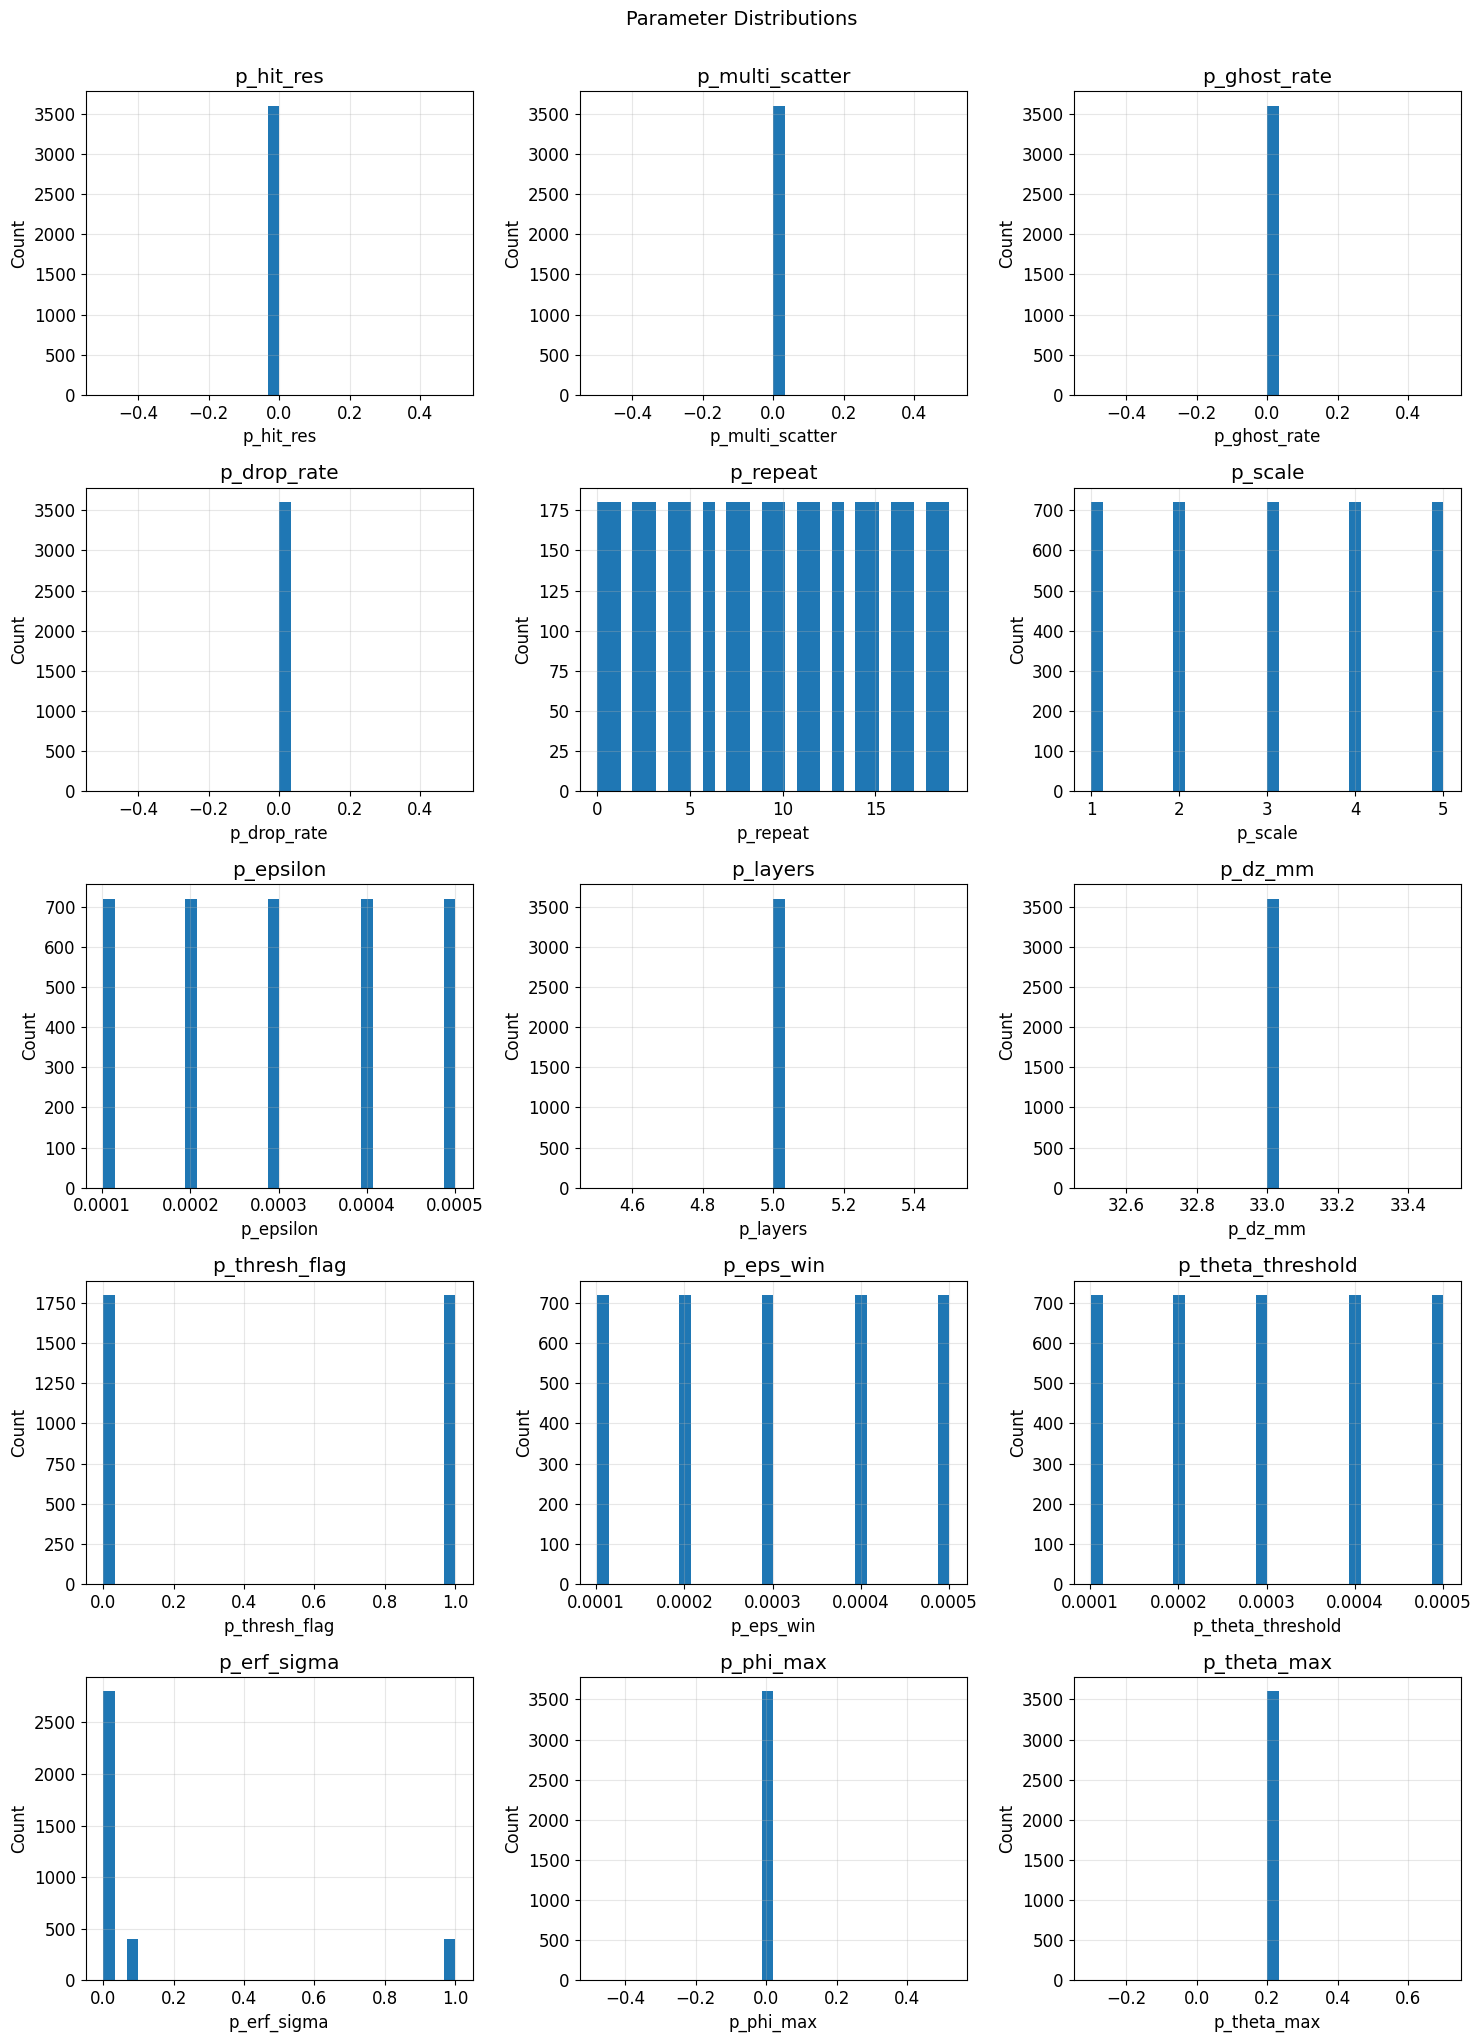

In [17]:
# Parameter distributions
if metrics is not None:
    parameters = [c for c in metrics.columns if c.startswith('p_')]
    n_params = len(parameters)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, param in enumerate(parameters):
        metrics[param].hist(ax=axes[i], bins=30)
        axes[i].set_title(f'{param}')
        axes[i].set_xlabel(param)
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3)

    for i in range(len(parameters), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Parameter Distributions', y=1.02, fontsize=14)
    plt.show()

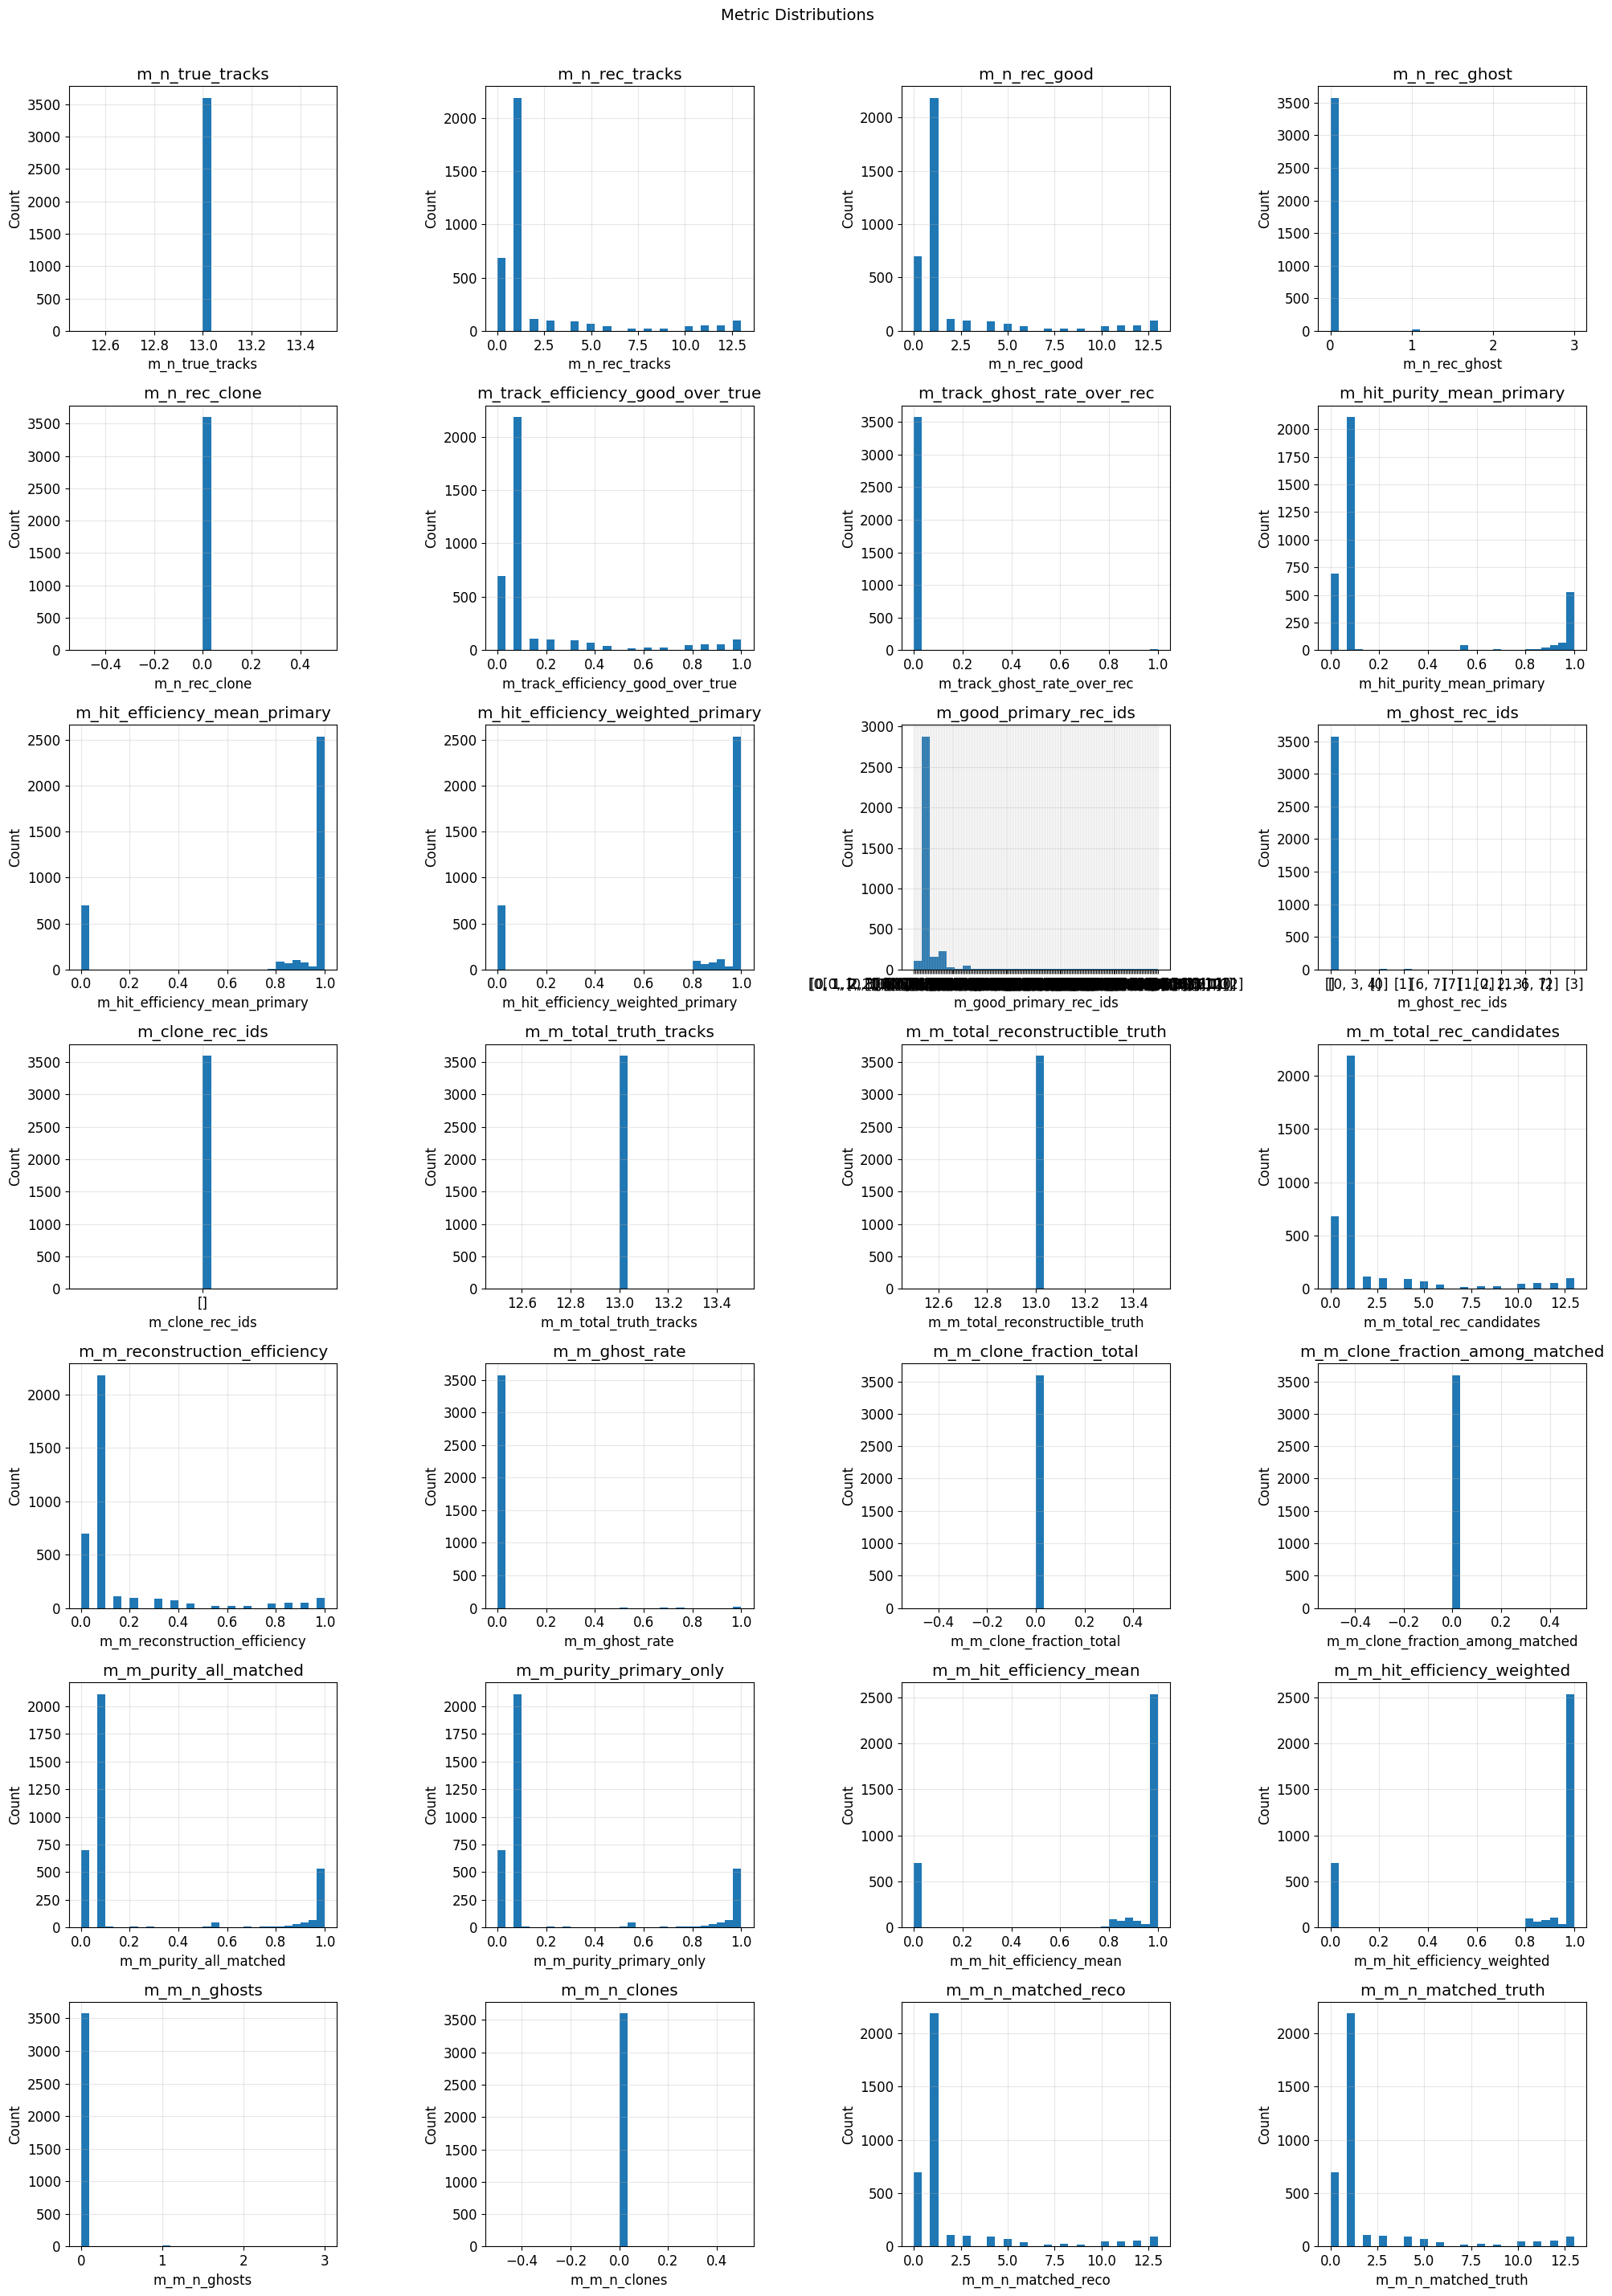

In [18]:
# Metric distributions
if metrics is not None:
    m_columns = [col for col in metrics.columns if col.startswith('m_')]
    n_cols_m = len(m_columns)
    n_cols_grid = 4
    n_rows_grid = (n_cols_m + n_cols_grid - 1) // n_cols_grid

    fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(20, 4 * n_rows_grid))
    axes = axes.flatten()

    for i, col in enumerate(m_columns):
        metrics[col].hist(ax=axes[i], bins=30)
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3)

    for i in range(len(m_columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Metric Distributions', y=1.02, fontsize=14)
    plt.show()

---
<a id='parameter-scans'></a>
## 8. Parameter Scans

Systematic analysis of performance vs. physics parameters.

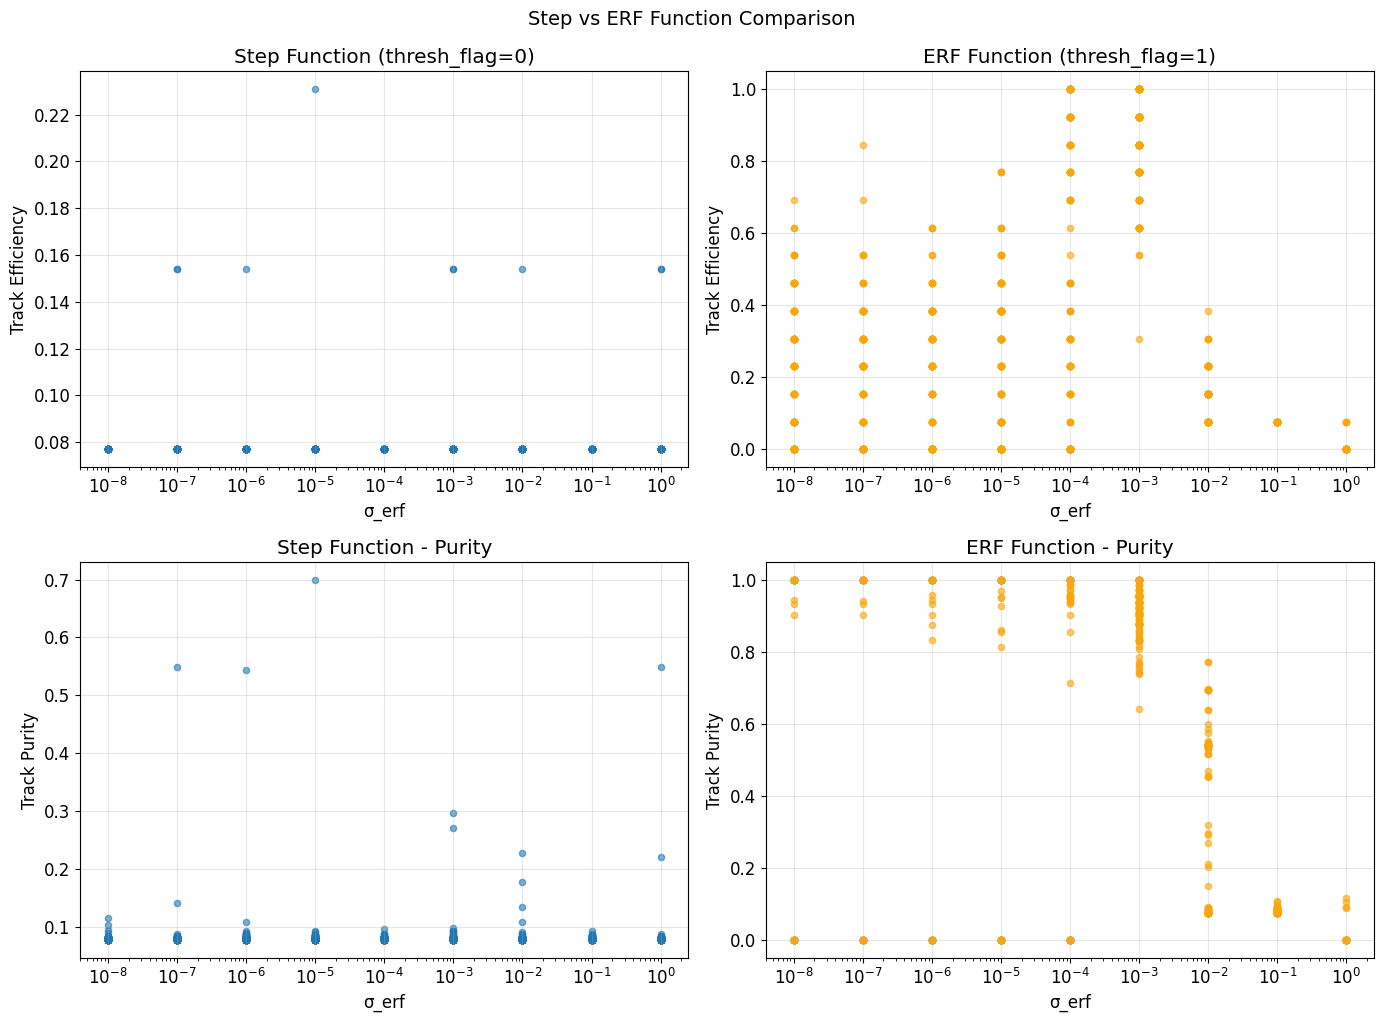

In [19]:
# =============================================================================
# STEP vs ERF FUNCTION COMPARISON
# =============================================================================

if metrics is not None and 'p_thresh_flag' in metrics.columns:
    step_func = metrics[metrics['p_thresh_flag'] == 0]
    erf_func = metrics[metrics['p_thresh_flag'] == 1]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Track efficiency
    axes[0, 0].scatter(step_func['p_erf_sigma'], 
                       step_func['m_m_reconstruction_efficiency'], 
                       alpha=0.6, s=20, label='Step')
    axes[0, 0].set_xlabel('σ_erf')
    axes[0, 0].set_ylabel('Track Efficiency')
    axes[0, 0].set_title('Step Function (thresh_flag=0)')
    axes[0, 0].set_xscale('log')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(erf_func['p_erf_sigma'], 
                       erf_func['m_m_reconstruction_efficiency'], 
                       alpha=0.6, s=20, color='orange', label='ERF')
    axes[0, 1].set_xlabel('σ_erf')
    axes[0, 1].set_ylabel('Track Efficiency')
    axes[0, 1].set_title('ERF Function (thresh_flag=1)')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)

    # Track purity
    axes[1, 0].scatter(step_func['p_erf_sigma'], 
                       step_func['m_m_purity_all_matched'], 
                       alpha=0.6, s=20)
    axes[1, 0].set_xlabel('σ_erf')
    axes[1, 0].set_ylabel('Track Purity')
    axes[1, 0].set_title('Step Function - Purity')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].scatter(erf_func['p_erf_sigma'], 
                       erf_func['m_m_purity_all_matched'], 
                       alpha=0.6, s=20, color='orange')
    axes[1, 1].set_xlabel('σ_erf')
    axes[1, 1].set_ylabel('Track Purity')
    axes[1, 1].set_title('ERF Function - Purity')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Step vs ERF Function Comparison', y=1.02, fontsize=14)
    plt.show()

In [20]:
# =============================================================================
# MULTIPLE SCATTERING SCAN
# =============================================================================

if metrics is not None:
    # Fixed parameters
    fixed_params = {
        'p_hit_res': 0.0,
        'p_ghost_rate': 0.0,
        'p_drop_rate': 0.0,
        'p_repeat': 0
    }
    
    subset = sub_set_data(metrics, fixed_params)
    
    if len(subset) > 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(subset['p_multi_scatter'], 
                   subset['m_m_reconstruction_efficiency'], 
                   alpha=0.7, s=50)
        plt.xscale('log')
        plt.xlabel('Multiple Scattering Parameter')
        plt.ylabel('Track Reconstruction Efficiency')
        plt.title('Efficiency vs Multiple Scattering\n(Fixed: res=0, ghost=0, drop=0)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Data points: {len(subset)}")

In [21]:
# =============================================================================
# EXTENDED PLOTS (from lhcb_tracking_plots module)
# =============================================================================

if metrics is not None:
    # Step function subset
    subsets_step = {
        'p_scale': 4,
        'p_thresh_flag': 0
    }
    
    # ERF function subset  
    subsets_erf = {
        'p_scale': 4,
        'p_thresh_flag': 1
    }
    
    ss1 = sub_set_data(metrics, subsets_step)
    ss2 = sub_set_data(metrics, subsets_erf)
    
    print(f"Step function subset: {len(ss1)} rows")
    print(f"ERF function subset: {len(ss2)} rows")

Step function subset: 360 rows
ERF function subset: 360 rows


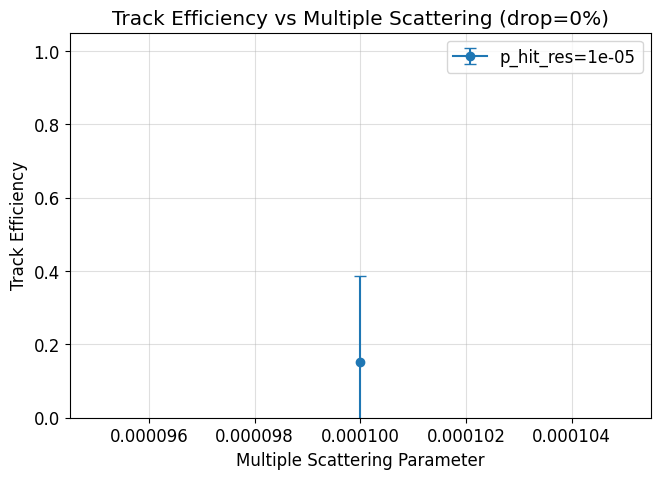

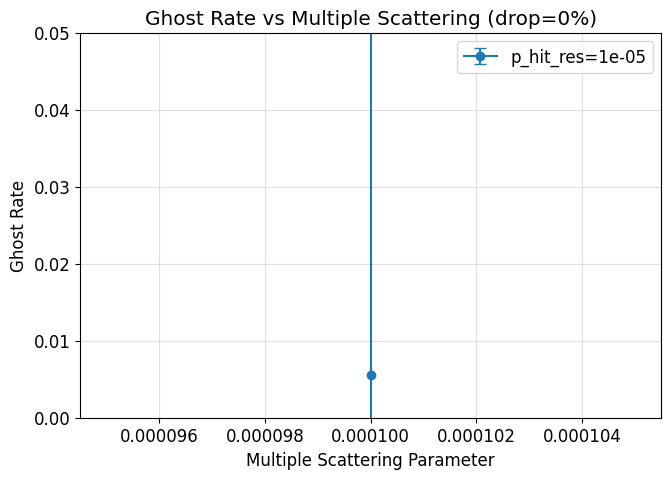

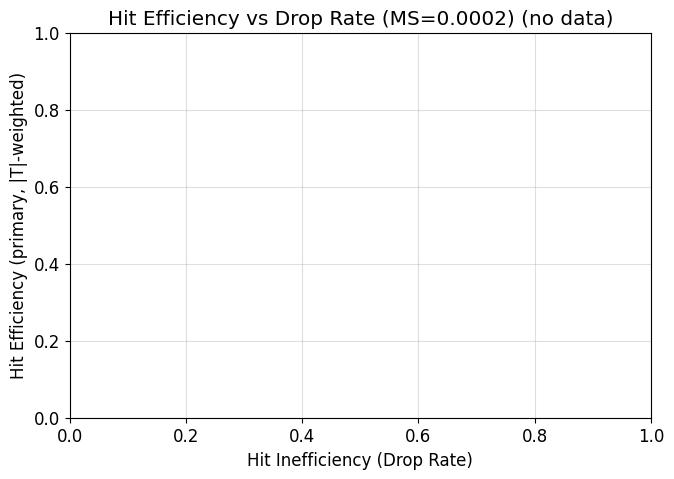

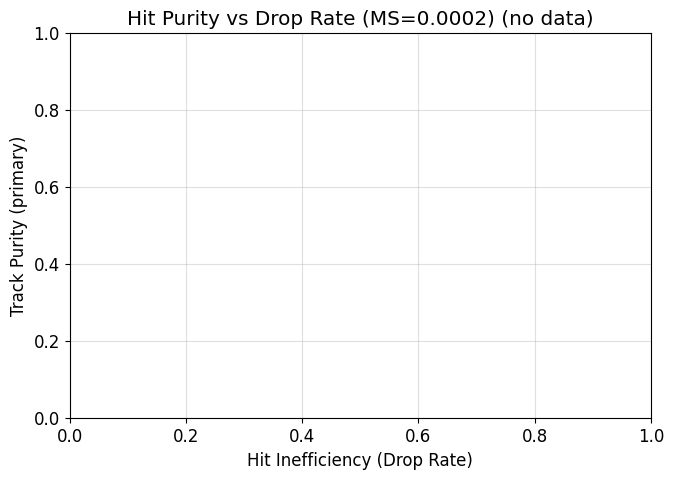

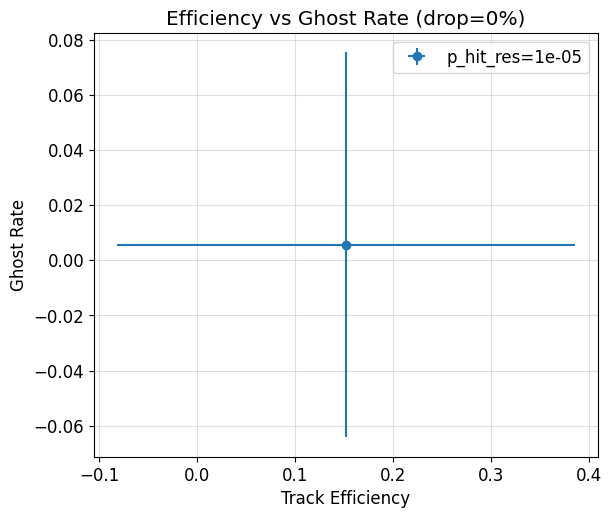

In [22]:
# Use the plotting module for comprehensive analysis
if metrics is not None and len(metrics) > 0:
    try:
        out = plot_all(metrics, out_prefix="perf", ms_fixed=2e-4)
    except Exception as ex:
        print(f"plot_all failed: {ex}")

---
## 9. Scratch / Sandbox

Space for exploratory analysis.

In [ ]:
# Sandbox cell for exploratory work